# Text classification with RNN

In this notebook we will cover a couple of tips and tricks for tweaking a neural text classifier. We will use an LSTM model for our experiments. We use torch version 1.4.
The code is inspired by [this](https://github.com/lukysummer/Movie-Review-Sentiment-Analysis-LSTM-Pytorch/blob/master/sentiment_analysis_LSTM.py) repository.

### 1. LOAD THE TRAINING TEXT

In [ ]:
from sklearn.datasets import load_files

In [ ]:
from nltk import download

In [ ]:
download("movie_reviews", download_dir="data")

[nltk_data] Downloading package movie_reviews to data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [ ]:
movies = load_files("./data/corpora/movie_reviews")

In [ ]:
reviews, encoded_labels = [review.decode() for review in movies.data], movies.target

In [ ]:
import pandas as pd

df_reviews = pd.DataFrame({'reviews': reviews, 'encoded_labels': encoded_labels})
df_reviews

,reviews,encoded_labels
0,arnold schwarzenegger has been an icon for act...,0
1,good films are hard to find these days . \ngre...,1
2,quaid stars as a man who has taken up the prof...,1
3,we could paraphrase michelle pfieffer's charac...,0
4,kolya is one of the richest films i've seen in...,1
...,...,...
1995,"under any other circumstances , i would not be...",0
1996,bruce barth's mellow piano plays in the backgr...,1
1997,""" a man is not a man without eight taels of g...",1
1998,this is a film that i was inclined to like at ...,0


### 2. TEXT PRE-PROCESSING

In [ ]:
from string import punctuation
import re

word_re = re.compile(r"\b[a-z]{2,}\b")

def tokenize(text):
    processed_text = "".join(ch for ch in text.lower() if ch not in punctuation)
    processed_text = processed_text.replace("\n", " ")
    return word_re.findall(processed_text)

def flatten(tokenized_texts):
    return [word for text in tokenized_texts for word in text]

In [ ]:
all_reviews = df_reviews['reviews'].apply(tokenize)
all_words = pd.Series(flatten(all_reviews))
all_words

,0
0,arnold
1,schwarzenegger
2,has
3,been
4,an
...,...
1239602,go
1239603,about
1239604,getting
1239605,the


### 3. CREATE DICTIONARIES & ENCODE REVIEWS

In [ ]:
import gensim.downloader as api
import pandas as pd

pd.DataFrame(api.info()['models']).head().T;

In [ ]:
embed_size = 100
wv = api.load(f'glove-wiki-gigaword-{embed_size}')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# word_counts = all_words.value_counts()
# word_ids = range(1, word_counts.size+1)
# int_to_vocab = pd.Series(word_counts.index, index=word_ids)
# vocab_to_int = pd.Series(word_ids, index=word_counts.index)
# encoded_reviews = all_reviews.apply(lambda x: vocab_to_int[x].values)
# encoded_reviews

In [ ]:
vocab = pd.Series(wv.key_to_index) + 1
encoded_reviews = all_reviews.apply(lambda x: [vocab.get(w, 0) for w in x])
encoded_reviews

,reviews
0,"[5819, 6681, 32, 52, 30, 7884, 11, 609, 14345,..."
1,"[220, 1589, 33, 606, 5, 597, 159, 250, 354, 15..."
2,"[32011, 1570, 20, 301, 39, 32, 493, 61, 1, 0, ..."
3,"[54, 95, 43505, 7085, 0, 1396, 7, 2293, 5837, ..."
4,"[113936, 15, 49, 4, 1, 8570, 1589, 79290, 542,..."
...,...
1995,"[125, 131, 69, 3499, 55, 37, 31, 5641, 1, 1946..."
1996,"[3966, 398596, 28899, 4810, 1382, 7, 1, 2094, ..."
1997,"[301, 15, 37, 301, 297, 503, 172508, 4, 765, 3..."
1998,"[38, 15, 320, 13, 16, 11730, 5, 118, 23, 1, 14..."


In [ ]:
# from collections import Counter

# word_counts = Counter(all_words)
# word_list = sorted(word_counts, key=lambda k: word_counts[k], reverse = True)
# vocab_to_int = {word:idx+1 for idx, word in enumerate(word_list)}
# int_to_vocab = {idx:word for word, idx in vocab_to_int.items()}
# encoded_reviews = all_reviews.apply(lambda x: vocab_to_int[x].values)
# # encoded_reviews = [[vocab_to_int[word] for word in review] for review in all_reviews]

### 6. MAKE ALL REVIEWS SAME LENGTH

In [ ]:
import numpy as np
import torch

# encoded_labels = np.array( [label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx]) > 0] )
# encoded_reviews = [review for review in encoded_reviews if len(review) > 0]

In [ ]:
def pad_review(encoded_reviews, seq_length=200):
    review = encoded_reviews[:seq_length]
    padded_review = np.zeros(seq_length, dtype=int)
    padded_review[-len(review):] = review
    return padded_review

padded_reviews = np.stack(encoded_reviews.apply(pad_review, seq_length=200))
padded_reviews

array([[ 5819,  6681,    32, ...,  1006,    21,   121],
       [  220,  1589,    33, ...,    49,    44,  1066],
       [32011,  1570,    20, ...,   908,  1696,  3645],
       ...,
       [  301,    15,    37, ...,     4,  5093,  7017],
       [   38,    15,   320, ...,     1,  2470,    11],
       [  131, 11169,     4, ...,     4, 12570,    11]])

In [ ]:
# def pad_text(encoded_reviews, seq_length):

#     reviews = []

#     for review in encoded_reviews:
#         if len(review) >= seq_length:
#             reviews.append(review[:seq_length])
#         else:
#             reviews.append([0] * (seq_length - len(review)) + review)

#     return np.array(reviews)

# padded_reviews = pad_text(encoded_reviews, seq_length=200)

In [ ]:
def pad_batch(batch, seq_length=200):
    max_len = max(map(len, batch))
    seq_length = min(seq_length, max_len)
    padded_batch = [pad_review(review, seq_length=seq_length) for review in batch]
    return padded_batch


```
[0 0 1 1 1 1 2 2 2]
[0 1 1 1 1 1 2 2 2]
[1 1 1 1 1 1 2 2 2]
[0 0 1]
[0 1 2]
[2 3 4]
[0 0 1 1 1 1]
[0 1 1 1 1 1]
[1 1 1 1 1 1]
```



### 7. SPLIT DATA & GET (REVIEW, LABEL) DATALOADER

In [ ]:
train_ratio = 0.8
valid_ratio = (1 - train_ratio)/2
total = padded_reviews.shape[0]
train_cutoff = int(total * train_ratio)
valid_cutoff = int(total * (1 - valid_ratio))

train_x, train_y = torch.from_numpy(padded_reviews[:train_cutoff]), torch.from_numpy(encoded_labels[:train_cutoff])
valid_x, valid_y = torch.from_numpy(padded_reviews[train_cutoff:valid_cutoff]), torch.from_numpy(encoded_labels[train_cutoff:valid_cutoff])
test_x, test_y = torch.from_numpy(padded_reviews[valid_cutoff:]), torch.from_numpy(encoded_labels[valid_cutoff:])

from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(train_x, train_y)
valid_data = TensorDataset(valid_x, valid_y)
test_data = TensorDataset(test_x, test_y)

BATCH_SIZE = 250
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

### 8. DEFINE THE LSTM MODEL

During the model definition step, we might re-implement model weight initialisation, apply another tricks such as adding various types of dropout to the needed layers etc. There is a noteworthy [discussion](https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch) on wheather one should initialize weights manually or not, and, if yes, how? The functions that implement various initialisation methods are located in the `torch.nn.init` module.

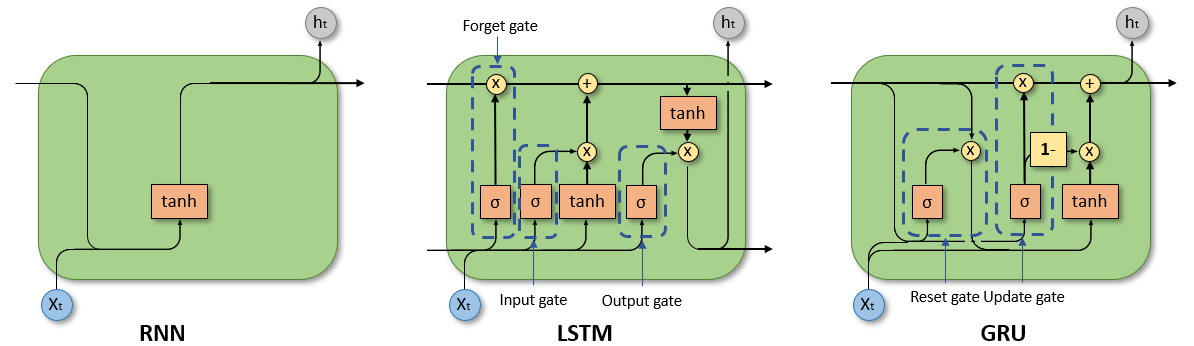

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i_linear = nn.Linear(input_size, hidden_size)
        self.h_linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden()
        for elem in x:
            hidden = torch.tanh(self.i_linear(elem) + self.h_linear(hidden))
        return hidden

    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

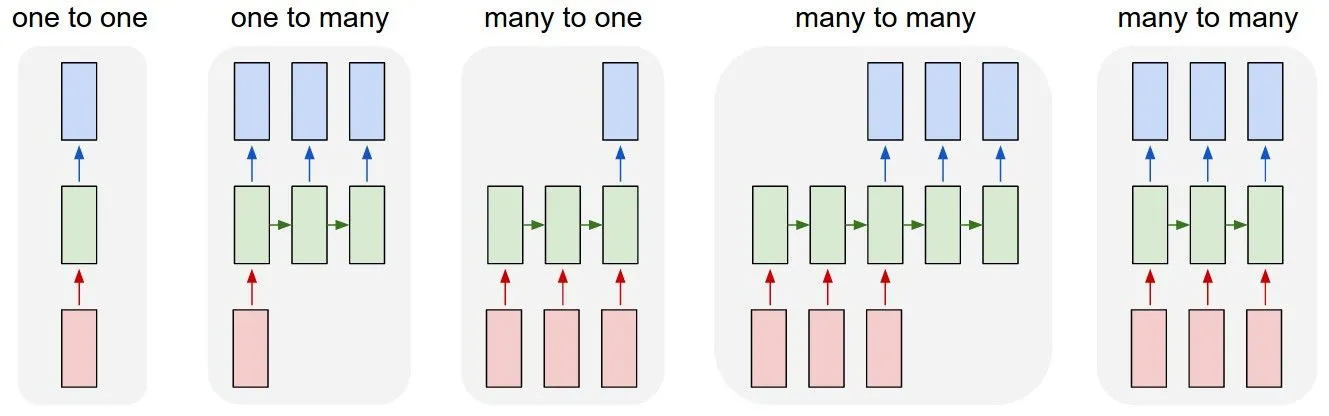

In [ ]:
# torch.cat
wv_torch = torch.from_numpy(wv.vectors)
pad = torch.zeros((1, wv_torch.shape[1]))
wv_torch_with_pad = torch.cat((pad, wv_torch), dim=0)

In [ ]:
# class LinearModel(nn.Module):
#     def __init__(self, embed_size=embed_size, hidden_size=128, n_classes=4):
#         super().__init__()
#         self.emb = nn.Embedding.from_pretrained(wv_torch_with_pad)
#         self.linear = nn.Linear(embed_size, hidden_size)
#         self.rnn = RNN(embed_size, hidden_size)
#         self.clf = nn.Linear(hidden_size, n_classes)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.emb(x)
#         x = self.rnn(x)
#         x = self.clf(x)
#         output = self.softmax(x)
#         return output

In [ ]:
class SentimentLSTM(nn.Module):

    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.3):
        super().__init__()
        # params: "n_" means dimension

        self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM

        self.embedding = nn.Embedding.from_pretrained(wv_torch_with_pad)
        # self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.dropout = nn.Dropout(drop_p) # this layer is designed to turn any neuron off with probability drop_p
        self.sigmoid = nn.Sigmoid()
        self.__init_linear()


    def forward (self, input_words, hidden_state=None):      # INPUT   :  (batch_size, seq_length)
        # embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        # lstm_out, h = self.lstm(embedded_words, hidden_state) # (batch_size, seq_length, n_hidden)
        # lstm_out = self.dropout(lstm_out)
        # lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        # fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        # sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        # sigmoid_out = sigmoid_out.view(input_words.shape[0], -1)  # (batch_size, seq_length*n_output)

        # # extract the output of ONLY the LAST output of the LAST element of the sequence
        # sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)

        # return sigmoid_last, h

        h = (
            nn.init.kaiming_uniform_(torch.empty(self.n_layers, input_words.shape[0], self.n_hidden)).to(input_words.device),
            nn.init.kaiming_uniform_(torch.empty(self.n_layers, input_words.shape[0], self.n_hidden)).to(input_words.device),
            )
        x = self.embedding(input_words)
        x, _ = self.lstm(x, h)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

    def __init_linear(self):
        self.fc.weight.data.normal_(0.0, 1/np.sqrt(self.n_hidden))
        self.fc.bias.data.fill_(0)


    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))

        return h

In [ ]:
inputs.shape

torch.Size([250, 200])

In [ ]:
for inputs, labels in (train_loader):
    break
net.to(device)
x = inputs.to('cuda')
x = net.embedding(x)
x, _ = net.lstm(x, h)
x.shape
# x = x[:, -1, :]
# x = net.fc(x)
# x = net.sigmoid(x)
# x

NameError: name 'h' is not defined

In [ ]:
x.shape

NameError: name 'x' is not defined

[source](https://discuss.pytorch.org/t/initialization-of-first-hidden-state-in-lstm-and-truncated-bptt/58384)
```python
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out
```



### 9. INSTANTIATE THE MODEL W/ HYPERPARAMETERS

In [ ]:
# n_vocab = len(vocab_to_int)
# n_embed = 100
n_vocab = wv_torch_with_pad.shape[0]
n_embed = wv_torch_with_pad.shape[1]
n_hidden = 256
n_output = 1   # 1 ("positive") or 0 ("negative")
n_layers = 2

net = SentimentLSTM(n_vocab, n_embed, n_hidden, n_output, n_layers)

### 10. DEFINE LOSS & OPTIMIZER

L2-regularization is already included into SGD optimizer. The `weight_decay` parameter is responsible for controlling its intensity.

In [ ]:
from torch import optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, weight_decay=1e-5)

### 11. TRAIN THE NETWORK!

To prevent the exploding gradient problem in LSTM/RNN we use the `clip_grad_norm_` function, that takes the `clip` parameter.


In [ ]:
temp = next(iter(train_loader))
temp[0].shape

torch.Size([250, 200])

In [ ]:
from tqdm import tqdm

print_every = 100
step = 0
n_epochs = 100  # validation loss increases from ~ epoch 3 or 4
clip = 5  # gradient clip to prevent exploding gradient problem in LSTM/RNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net.train()

for epoch in tqdm(range(n_epochs)):
    # h = net.init_hidden(BATCH_SIZE)

    for inputs, labels in tqdm(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)

        # making requires_grad = False for the latest set of h
        # h = net.init_hidden(BATCH_SIZE)
        # h = tuple([each.data for each in h])

        # net.zero_grad()
        # output, h = net(inputs, h)
        output = net(inputs)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()

        if (step % print_every) == 0:
            ######################
            ##### VALIDATION #####
            ######################
            net.eval()
            valid_losses = []
            v_h = net.init_hidden(BATCH_SIZE)

            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = inputs.to(device), labels.to(device)

                # v_h = tuple([each.data for each in v_h])

                # v_output, v_h = net(v_inputs, v_h)
                v_output = net(v_inputs)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())

            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            net.train()

 57%|█████▋    | 4/7 [00:00<00:00, 11.47it/s]

Epoch: 15/100 Step: 100 Training Loss: 0.6931 Validation Loss: 0.6934



 86%|████████▌ | 6/7 [00:00<00:00, 10.58it/s]

Epoch: 29/100 Step: 200 Training Loss: 0.6929 Validation Loss: 0.6930


 43%|████▎     | 43/100 [00:29<00:38,  1.47it/s]

Epoch: 43/100 Step: 300 Training Loss: 0.6927 Validation Loss: 0.6925



 43%|████▎     | 3/7 [00:00<00:00, 11.27it/s]

Epoch: 58/100 Step: 400 Training Loss: 0.6941 Validation Loss: 0.6935



 57%|█████▋    | 4/7 [00:00<00:00,  9.55it/s]

Epoch: 72/100 Step: 500 Training Loss: 0.6932 Validation Loss: 0.6933



 86%|████████▌ | 86/100 [00:58<00:09,  1.45it/s]

Epoch: 86/100 Step: 600 Training Loss: 0.6931 Validation Loss: 0.6931



100%|██████████| 100/100 [01:08<00:00,  1.47it/s]

Epoch: 100/100 Step: 700 Training Loss: 0.6944 Validation Loss: 0.6945


### 12. TEST THE TRAINED MODEL ON THE TEST SET

In [ ]:
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(BATCH_SIZE)
net.to(device)
for inputs, labels in test_loader:
    # test_h = tuple([each.data for each in test_h])
    inputs, labels = inputs.to(device), labels.to(device)
    # test_output, test_h = net(inputs, test_h)
    test_output = net(inputs)
    loss = criterion(test_output, labels.float().unsqueeze(dim=1))
    test_losses.append(loss.item())

    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct / len(test_loader.dataset)))

Test Loss: 0.6934
Test Accuracy: 0.48


In [ ]:
inputs, labels = next(iter(test_loader))

In [ ]:
test_h = net.init_hidden(BATCH_SIZE)
temp = net(inputs.to('cuda'), test_h)

In [ ]:
temp

tensor([[0.4996],
        [0.4951],
        [0.5042],
        [0.5032],
        [0.5019],
        [0.4998],
        [0.5036],
        [0.4981],
        [0.5003],
        [0.4993],
        [0.5053],
        [0.5006],
        [0.5030],
        [0.5025],
        [0.4998],
        [0.5033],
        [0.5017],
        [0.5041],
        [0.5025],
        [0.5012],
        [0.5026],
        [0.4983],
        [0.5060],
        [0.4997],
        [0.4999],
        [0.5000],
        [0.5030],
        [0.4986],
        [0.5025],
        [0.5021],
        [0.5027],
        [0.4974],
        [0.5059],
        [0.4981],
        [0.5013],
        [0.5013],
        [0.5003],
        [0.5025],
        [0.5012],
        [0.4964],
        [0.5032],
        [0.5043],
        [0.5018],
        [0.4990],
        [0.5017],
        [0.4973],
        [0.4988],
        [0.4998],
        [0.5018],
        [0.5046],
        [0.5039],
        [0.5002],
        [0.5040],
        [0.5022],
        [0.5003],
        [0

### 13. TEST THE TRAINED MODEL ON A RANDOM SINGLE REVIEW

In [ ]:
def predict(net, review, seq_length=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    words = tokenize(review)
    encoded_words = [vocab_to_int[word] for word in words]
    padded_words = pad_review(encoded_words, seq_length)
    padded_words = torch.from_numpy(padded_words.reshape(1, -1)).to(device)

    if(len(padded_words) == 0):
        "Your review must contain at least 1 word!"
        return None

    net.eval()
    h = net.init_hidden(1)
    # output, h = net(padded_words, h)
    output = net(padded_words)
    pred = torch.round(output.squeeze())
    msg = "This is a positive review." if pred == 0 else "This is a negative review."

    print(msg)


review1 = "It made me cry."
review2 = "It was so good it made me cry."
review3 = "It's ok."
review4 = "This movie had the best acting and the dialogue was so good. I loved it."
review5 = "Garbage"
                       ### OUTPUT ###
predict(net, review1)  ## negative ##
predict(net, review2)  ## positive ##
predict(net, review3)  ## negative ##
predict(net, review4)  ## positive ##
predict(net, review5)  ## negative ##

NameError: name 'vocab_to_int' is not defined

# Tagging

[source](https://github.com/baaraban/pytorch_ner)

Prepare data:

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    ("EU rejects German call to boycott British lamb .".split(), ["B-ORG", "O", "B-MISC", "O", "O", "O", "B-MISC", "O", "O"]),
    ("Only France and Britain backed Fisher 's proposal .".split(), ["O", "B-LOC", "O", "B-LOC", "O", "B-PER", "O", "O", "O"]),
    ("Germany imported 47,600 sheep from Britain last year , nearly half of total imports .".split(),
                                          ["B-LOC", "O", "O", "O", "O", "B-LOC", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),
    ("Rare Hendrix song draft sells for almost $ 17,000 .".split(), ["O", "B-PER", "O", "O", "O", "O", "O", "O", "O", "O"]),
    ("The guitarist died of a drugs overdose in 1970 aged 27 .".split(), ["O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),
    ("China says Taiwan spoils almosphere for talks .".split(), ["B-LOC", "O", "B-LOC", "O", "O", "O", "O", "O"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"O": 0, "B-ORG": 1, "B-LOC": 2, "B-PER": 3, "B-MISC": 4}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'EU': 0, 'rejects': 1, 'German': 2, 'call': 3, 'to': 4, 'boycott': 5, 'British': 6, 'lamb': 7, '.': 8, 'Only': 9, 'France': 10, 'and': 11, 'Britain': 12, 'backed': 13, 'Fisher': 14, "'s": 15, 'proposal': 16, 'Germany': 17, 'imported': 18, '47,600': 19, 'sheep': 20, 'from': 21, 'last': 22, 'year': 23, ',': 24, 'nearly': 25, 'half': 26, 'of': 27, 'total': 28, 'imports': 29, 'Rare': 30, 'Hendrix': 31, 'song': 32, 'draft': 33, 'sells': 34, 'for': 35, 'almost': 36, '$': 37, '17,000': 38, 'The': 39, 'guitarist': 40, 'died': 41, 'a': 42, 'drugs': 43, 'overdose': 44, 'in': 45, '1970': 46, 'aged': 47, '27': 48, 'China': 49, 'says': 50, 'Taiwan': 51, 'spoils': 52, 'almosphere': 53, 'talks': 54}


Create the model:

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Train the model:

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "EU rejects German call to boycott British lamb .".
    # i,j corresponds to score for tag j for word i. The predicted tag is
    # the maximum scoring tag.
    # Here, we can see the predicted sequence below is 1 0 2 0 0 0 2 0 0
    # since 1 is index of the maximum value of row 1,
    # 0 is the index of maximum value of row 2, etc.
    # Which is B-ORG O B-MISC O..., the correct sequence!
    print(tag_scores)

tensor([[-1.7318, -2.0072, -1.3219, -1.4284, -1.7018],
        [-1.5456, -2.1472, -1.3576, -1.5557, -1.6009],
        [-1.6934, -2.0625, -1.3707, -1.4036, -1.6642],
        [-1.6405, -2.0375, -1.4234, -1.4200, -1.6443],
        [-1.6193, -1.9612, -1.4729, -1.4532, -1.6184],
        [-1.6240, -2.0439, -1.5307, -1.4145, -1.5420],
        [-1.6078, -2.1017, -1.5134, -1.3892, -1.5702],
        [-1.5866, -2.1500, -1.4780, -1.4220, -1.5628],
        [-1.6069, -2.0913, -1.4214, -1.4397, -1.6215]])
tensor([[-5.0487e+00, -4.6411e-01, -1.3104e+00, -3.6776e+00, -2.6607e+00],
        [-9.9320e-02, -5.2737e+00, -3.5002e+00, -3.5282e+00, -3.5107e+00],
        [-2.5974e+00, -2.4867e+00, -3.6655e+00, -1.5256e+00, -5.1203e-01],
        [-1.7055e-02, -7.9594e+00, -7.5915e+00, -4.8487e+00, -4.8015e+00],
        [-5.0568e-04, -1.0675e+01, -1.0791e+01, -8.6217e+00, -8.1747e+00],
        [-3.8499e-02, -7.6951e+00, -7.3890e+00, -4.2124e+00, -3.8220e+00],
        [-2.4814e+00, -4.8910e+00, -4.1896e+00, -1.078

## Task

Initialize model embedding layer with pre-trained word2vec embeddings. Train new model with obtained layer. Compare results with  on test dataset.